In [9]:
import numpy as np
import matplotlib.pyplot as plt
import json
from playsound import playsound

# Subproject5 Visualization
### Load Model Training Output Data
From the previous section, we stored the model training outputs. We will use this cached data for visualization purposes. This is so we do not have to train our model every time before we want to analyze the results.

In [23]:
gd_output_filename = "./output/2022-02-10_17-53-23.760112_GD_degree-1_epochs-100_eta-0.01-0.001-0.0001_lam-10-5-1-0.1-0.01.json"

# load our data
with open(gd_output_filename, "r") as file:
    json_str = file.read()
gd_training_output = json.loads(json_str)

training_results = gd_training_output["results"]
training_metadata = gd_training_output["metadata"]

# get metadata
max_degree = training_metadata["max_degree"]
training_epochs = training_metadata["training_epochs"]
eta_list = training_metadata["eta_list"]
lam_list = training_metadata["lam_list"]

### Optimal Training Hyperparameters
We can find the optimal training parameters by finding the training run that yielded the smallest validation error.

In [24]:
def print_training_result_item(item): 
    fields_to_display = ["degree", "epochs", "eta", "lam", "train_time", "min_train_mse", "min_train_mse_epoch", "min_test_mse", "min_test_mse_epoch"]
    
    for field in fields_to_display:
        field_data = item[field]
        print(f"\t{field}: {field_data}")
        
# print min MSEs
# find min MSE for test in training_results
min_test_mse_item = min(training_results, key=lambda x: x["min_test_mse"])
min_train_mse_item = min(training_results, key=lambda x: x["min_train_mse"])

print("train with minimum test MSE:")
print_training_result_item(min_test_mse_item)

train with minimum test MSE:
	degree: 1
	epochs: 100
	eta: 0.01
	lam: 0.01
	train_time: 0.004498481750488281
	min_train_mse: 0.03349094916558961
	min_train_mse_epoch: 100
	min_test_mse: 0.035085487300552345
	min_test_mse_epoch: 100


### Plotting Degree vs. MSE

Pseudo-Code for the algorithm below:
- for each degree
    - create fig, 
        
    - for the fig, create subplots; number of subplots = `len(lams) * len(etas) * 2`
    
    - for each $\eta$ value
        - on each subplot for $\eta$, plot all vals of $\lambda$ with legend

[    0     1     2 ...  9998  9999 10000]


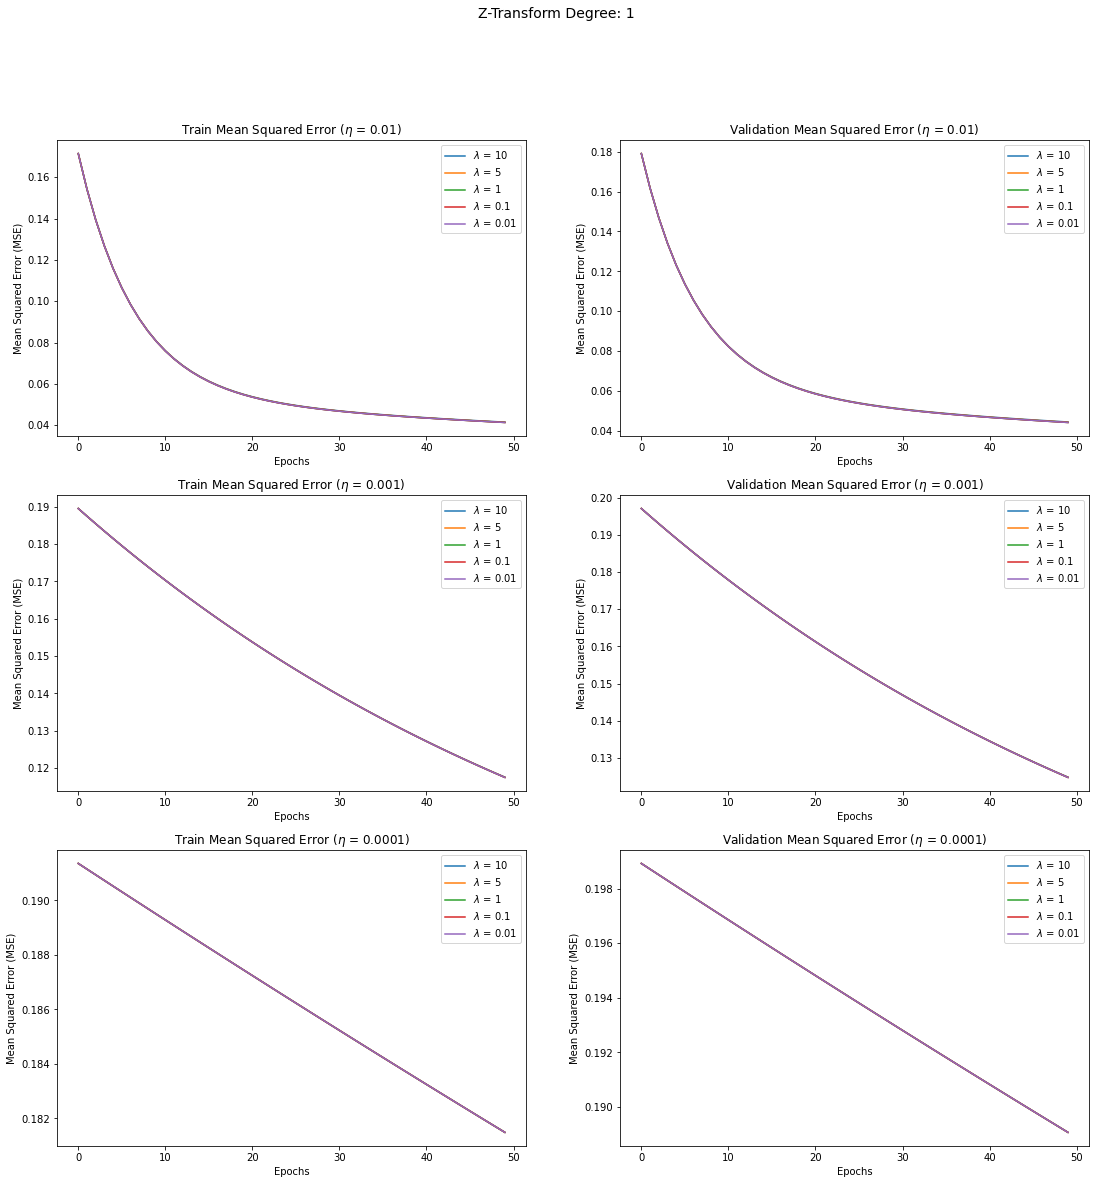

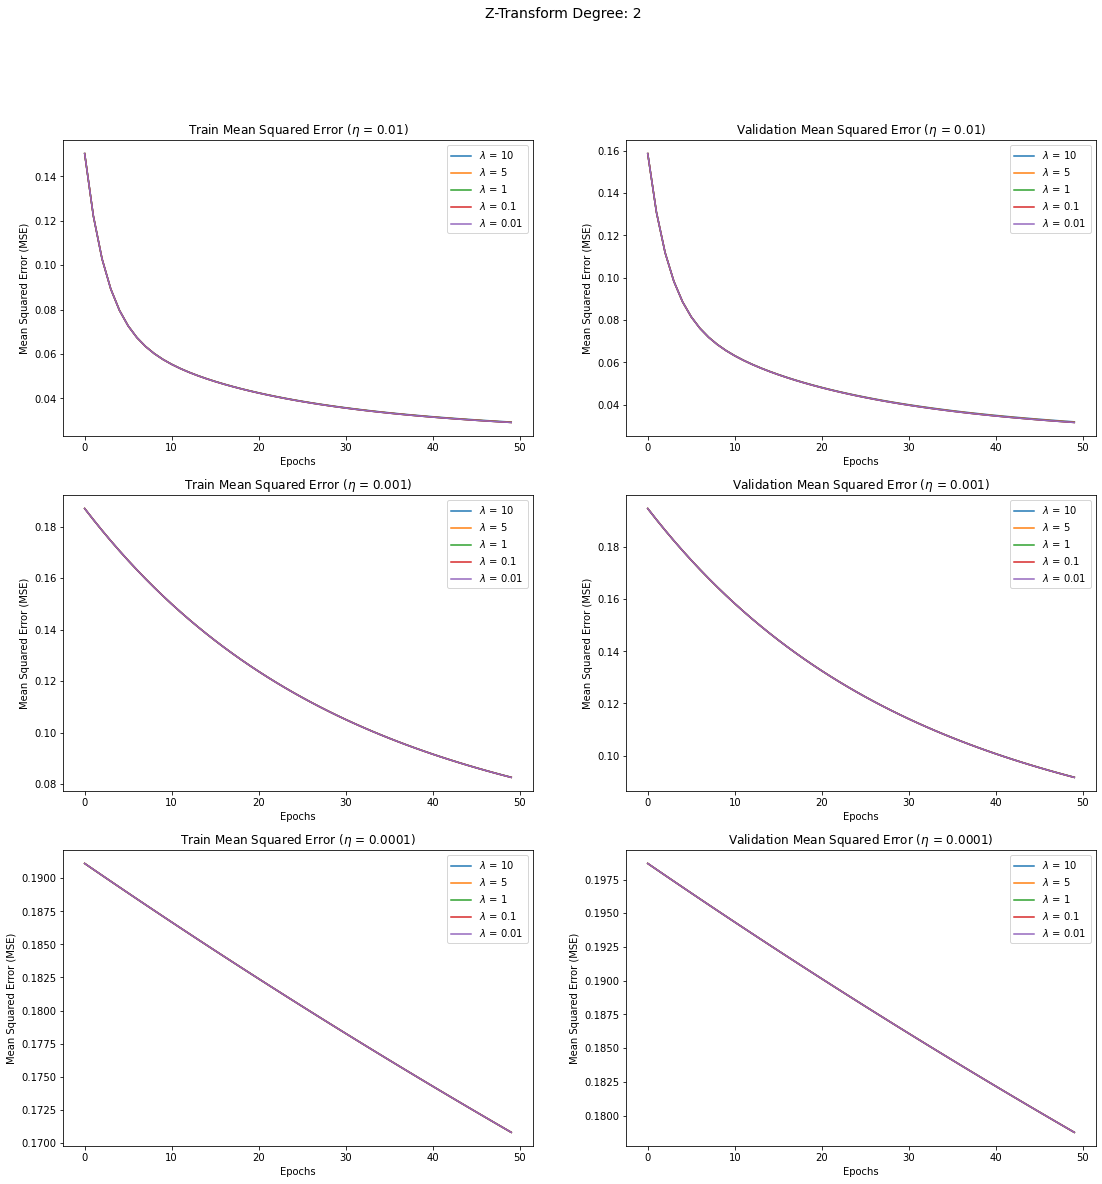

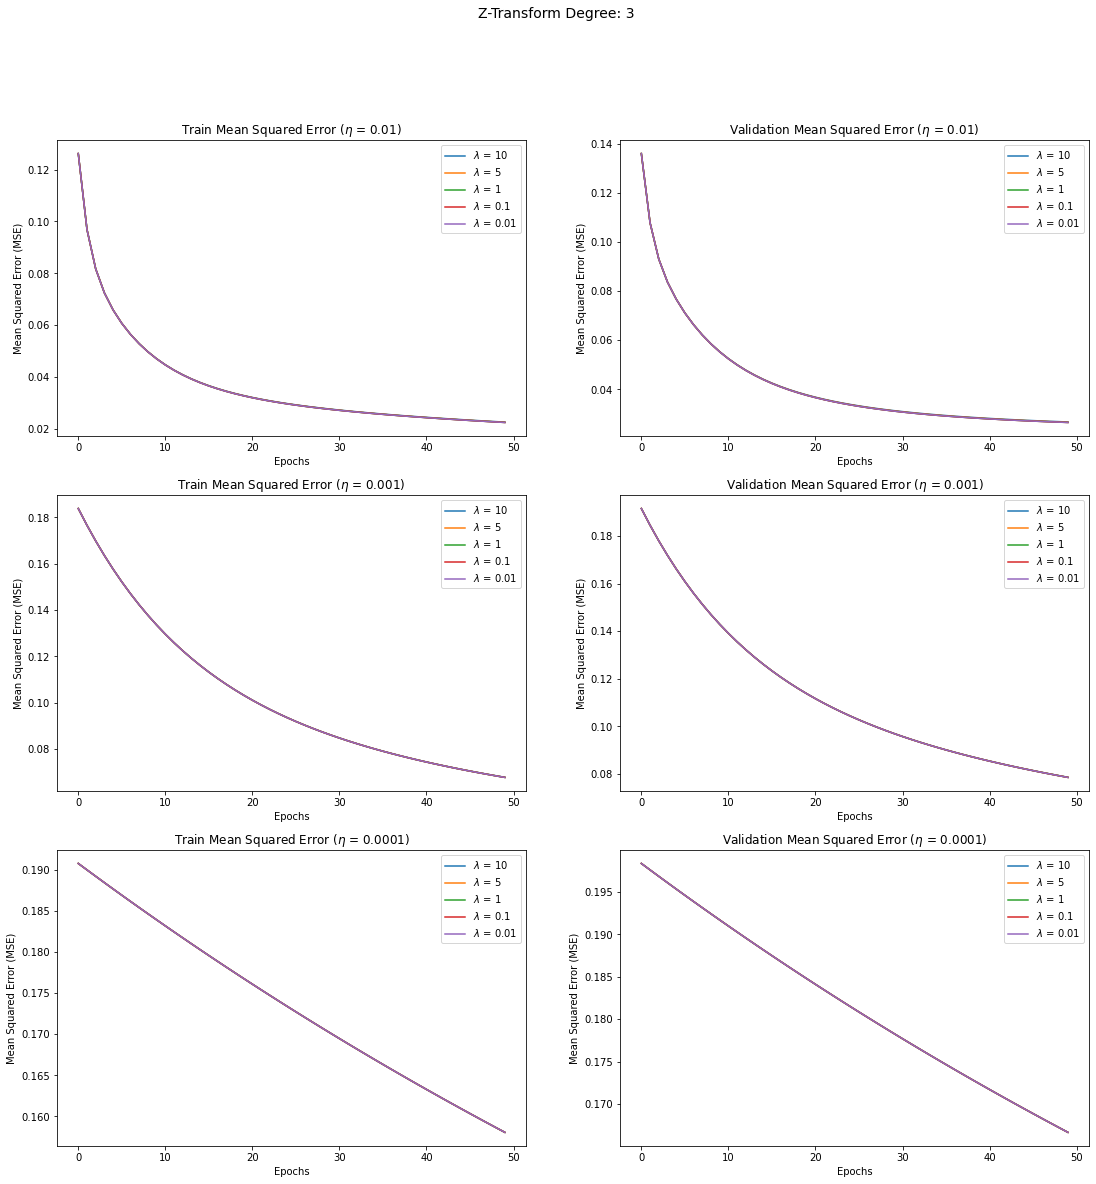

In [18]:
# plotting config
plot_output_path = "./output/plots/"
epoch_start_index = 0
epoch_end_index = 50
subplot_rows = len(eta_list)
subplot_cols = 2

# our x-axis
x_epochs = np.arange(training_epochs + 1)

print(x_epochs)

# for each degree we create a figure
for r in np.arange(1, max_degree + 1):
    degree_fig = plt.figure()
    
    # figure config    
    degree_fig.set_size_inches(18.5, 18.5)
    degree_fig.suptitle(f'Z-Transform Degree: {r}', fontsize=14)
    
    # subplot for each eta value
    for i, eta_val in enumerate(eta_list):
        
        train_mse_ax = degree_fig.add_subplot(subplot_rows, subplot_cols, 2 * i + 1)
        test_mse_ax = degree_fig.add_subplot(subplot_rows, subplot_cols, 2 * i + 2)
        
        train_mse_ax.set_title(f"Train Mean Squared Error ($\eta$ = {eta_val})")
        train_mse_ax.set_ylabel("Mean Squared Error (MSE)")
        train_mse_ax.set_xlabel("Epochs")
        
        test_mse_ax.set_title(f"Validation Mean Squared Error ($\eta$ = {eta_val})")
        test_mse_ax.set_ylabel("Mean Squared Error (MSE)")
        test_mse_ax.set_xlabel("Epochs")

        # plot a line on the subplot for each lambda
        for lam_val in lam_list:
        
            y_val = list(filter(lambda x: 
                                x["degree"] == r and 
                                x["epochs"] == training_epochs and 
                                x["eta"] == eta_val and 
                                x["lam"] == lam_val, 
                                training_results))
            
            y_train_mse = y_val[0]["train_mse"]
            y_test_mse = y_val[0]["test_mse"]

            train_mse_ax.plot(x_epochs[epoch_start_index:epoch_end_index], 
                              y_train_mse[epoch_start_index:epoch_end_index], 
                              label=f"$\lambda$ = {lam_val}")

            test_mse_ax.plot(x_epochs[epoch_start_index:epoch_end_index], 
                             y_test_mse[epoch_start_index:epoch_end_index], 
                             label=f"$\lambda$ = {lam_val}")

        train_mse_ax.legend()
        test_mse_ax.legend()
        
    # save output
    degree_fig.savefig(f"{plot_output_path}/gd_fig_degree-{r}-LAM_legend.jpeg") # TODO: make better name

plt.show()

Previous cell logic but now subplots for each $\lambda$ plotting all $\eta$ values

ValueError: num must be 1 <= num <= 6, not 7

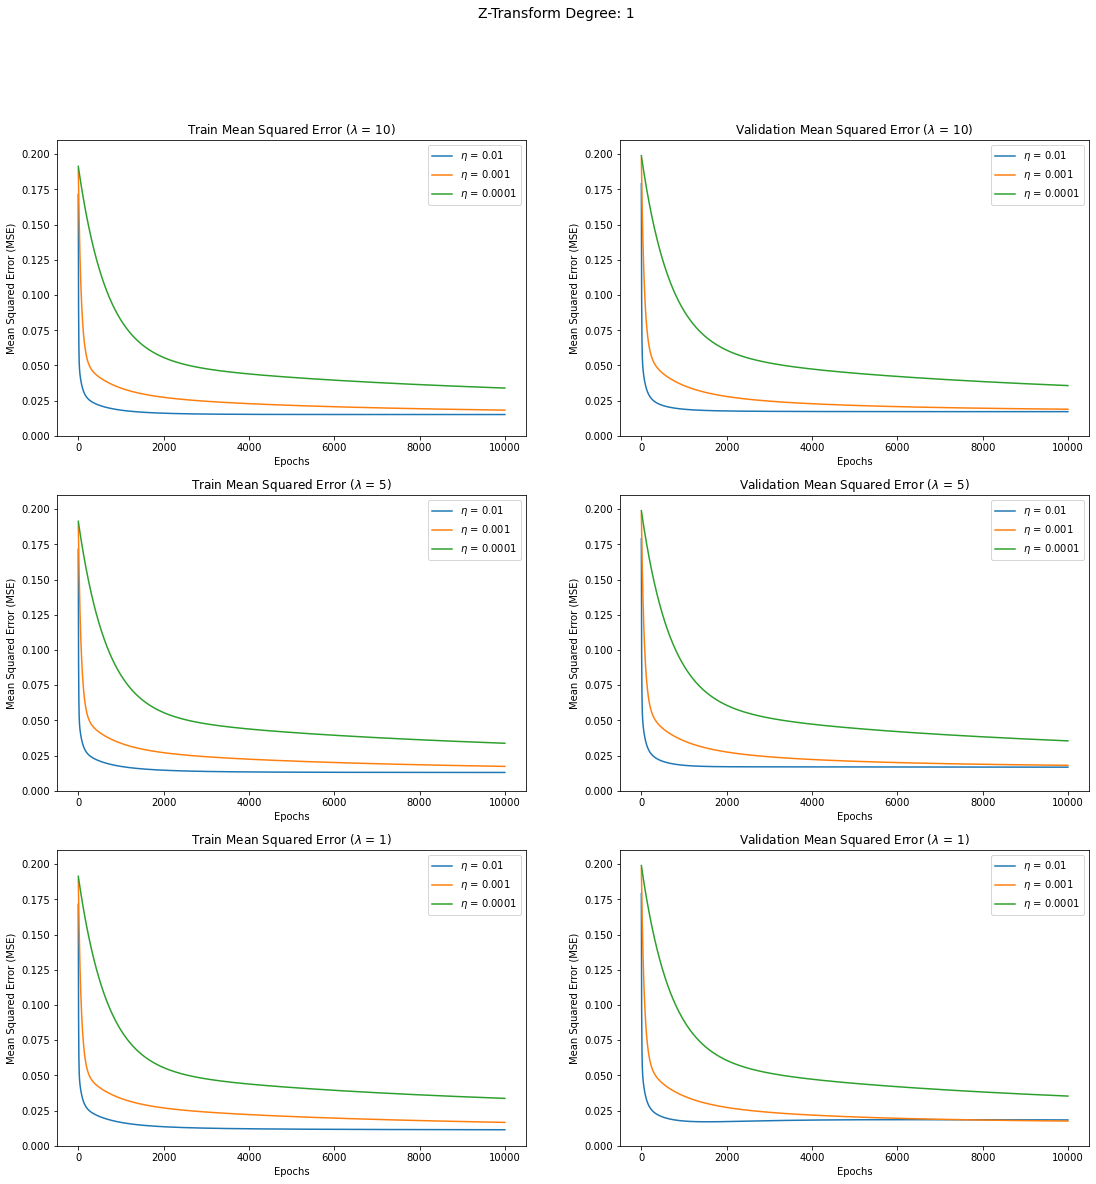

In [19]:
# plotting config
epoch_start_index = 0
epoch_end_index = 10_000
subplot_rows = len(eta_list)
subplot_cols = 2

# our x-axis
x_epochs = np.arange(training_epochs + 1)

# for each degree we create a figure
for r in np.arange(1, max_degree + 1):
    degree_fig = plt.figure()
    
    # figure config    
    degree_fig.set_size_inches(18.5, 18.5)
    degree_fig.suptitle(f'Z-Transform Degree: {r}', fontsize=14)
    
    # subplot for each eta value
    for i, lam_val in enumerate(lam_list):
        
        train_mse_ax = degree_fig.add_subplot(subplot_rows, subplot_cols, 2 * i + 1)
        test_mse_ax = degree_fig.add_subplot(subplot_rows, subplot_cols, 2 * i + 2)
        
        train_mse_ax.set_title(f"Train Mean Squared Error ($\lambda$ = {lam_val})")
        train_mse_ax.set_ylabel("Mean Squared Error (MSE)")
        train_mse_ax.set_xlabel("Epochs")
        
        test_mse_ax.set_title(f"Validation Mean Squared Error ($\lambda$ = {lam_val})")
        test_mse_ax.set_ylabel("Mean Squared Error (MSE)")
        test_mse_ax.set_xlabel("Epochs")

        # plot a line on the subplot for each lambda
        for eta_val in eta_list:
        
            y_val = list(filter(lambda x: 
                                x["degree"] == r and 
                                x["epochs"] == training_epochs and 
                                x["eta"] == eta_val and 
                                x["lam"] == lam_val, 
                                training_results))
            
            y_train_mse = y_val[0]["train_mse"]
            y_test_mse = y_val[0]["test_mse"]

            train_mse_ax.plot(x_epochs[epoch_start_index:epoch_end_index], 
                              y_train_mse[epoch_start_index:epoch_end_index], 
                              label=f"$\eta$ = {eta_val}")

            test_mse_ax.plot(x_epochs[epoch_start_index:epoch_end_index], 
                             y_test_mse[epoch_start_index:epoch_end_index], 
                             label=f"$\eta$ = {eta_val}")

        train_mse_ax.legend()
        test_mse_ax.legend()
        
        train_mse_ax.set_ylim([0, 0.21])
        test_mse_ax.set_ylim([0, 0.21])
        
    # save output
    degree_fig.savefig(f"{plot_output_path}/gd_fig_degree-{r}-ETA_legend.jpeg") # TODO: make better name

plt.show()